<a href="https://colab.research.google.com/github/imyixinw/CornellCSWiki/blob/master/2-conv1d_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1D Convolution on GPU

## 1. Set-up

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [5]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

%mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
!git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a3-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a3-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/ece5545

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a3-{YOUR_HANDLE}"

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ece5545’: File exists
/content/gdrive/MyDrive/ece5545
fatal: destination path 'a3-imyixinw' already exists and is not an empty directory.
/content/gdrive/MyDrive/ece5545/a3-imyixinw
M	src/ops.py
Already on 'main'
Your branch is up to date with 'origin/main'.
Already up to date.
/content/gdrive/MyDrive/ece5545


In [6]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

In [7]:
!ls {PROJECT_ROOT}

1-conv1d_cpu.ipynb  3-conv1d_fpga.ipynb  5-conv2d_dw_gpu.ipynb	README.md  tests
2-conv1d_gpu.ipynb  4-gemm_gpu.ipynb	 leaderboard_id.txt	src


## 2. Install TVM

In [6]:
# !pip install tlcpack-nightly-cu102 -f https://tlcpack.ai/wheels

!pip install numpy==1.24.3
!pip install tlcpack-nightly-cu102 -f https://tlcpack.ai/wheels

Looking in links: https://tlcpack.ai/wheels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 428.5/428.5 MB 3.5 MB/s eta 0:00:00


## 3. Implement `make_conv1d_gpu_scheduler_func` function in `src.ops`

In that function, you are required to implemented 1D convolution and use TVM to optimize it.
Let $x \in \mathbb{R}^m$ and $y \in \mathbb{R}^n$, then
$$
\operatorname{conv1d}(x, y)_i = \sum_{j=-\infty}^{\infty} x[j]y[i-j], \forall i \in \{0, 1, \dots, m + n - 1\}
$$

Please use zero padding and unit stride. Please see the numpy convolution function for more detail: [link](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html).

The `make_conv1d_gpu_scheduler_func` takes $m$ and $n$, which are the size of the two 1D input array.
You should return both the TVM scheduler and the TVM opterator for
1. Input $x$
2. Input $y$
3. Output $out$

The scheduler should be able to used to build a function with signature $func(x, y, out)$.
Please see the following cells for usage.

In [101]:
import tvm
import numpy as np
import sys
# Adding assignment 3 to the system path
# Make sure this matches your git directory
sys.path.insert(0, PROJECT_ROOT)
from src.ops import (
    make_conv1d_gpu_baseline,
    make_conv1d_gpu_refactored,
    make_conv1d_gpu_vectorize,
    make_conv1d_gpu_reorder,
    make_conv1d_gpu_shared_memory,
    make_conv1d_gpu_scheduler  # optimized version
)

M = 16384
N = 32
dtype = 'float32'
a_np = np.random.rand(M).astype(dtype)
w_np = np.random.rand(N).astype(dtype)
b_np = np.convolve(a_np, w_np)

optimization_funcs = {
    "baseline": make_conv1d_gpu_baseline,
    "refactored": make_conv1d_gpu_refactored,
    "vectorize": make_conv1d_gpu_vectorize,
    "reorder": make_conv1d_gpu_reorder,
    "shared_memory": make_conv1d_gpu_shared_memory,
    "optimized": make_conv1d_gpu_scheduler,
}
op_runtimes = {}


for name, make_schedule in optimization_funcs.items():
    print(f'Running {name}...')
    s, A, W, B = make_schedule(M, N)
    func = tvm.build(s, [A, W, B], "cuda")

    dev = tvm.cuda(0)
    a = tvm.nd.array(a_np, dev)
    w = tvm.nd.array(w_np, dev)
    b = tvm.nd.array(np.zeros((M+N-1), dtype), dev)
    func(a, w, b)
    evaluator = func.time_evaluator(func.entry_name, dev, number=1, repeat =1)


    print("Answer:", b_np)
    print("Output:", b)
    correct = np.allclose(b_np, b.numpy(), atol=1e-5)
    print('Correct:', correct)
    runtime_ms = evaluator(a, w, b).mean * 1e3
    print(f"1D conv TVM runtime: {runtime_ms:.6f} ms")

    op_runtimes[name] = runtime_ms

    print()

print(op_runtimes)

Running baseline...
Answer: [0.05131403 0.15750907 0.08065948 ... 0.969927   0.47037837 0.27748698]
Output: [0.05131403 0.15750907 0.08065948 ... 0.969927   0.47037837 0.27748698]
Correct: True
1D conv TVM runtime: 46.322689 ms

Running refactored...
Answer: [0.05131403 0.15750907 0.08065948 ... 0.969927   0.47037837 0.27748698]
Output: [0.05131403 0.15750907 0.08065948 ... 0.96992695 0.47037837 0.27748698]
Correct: True
1D conv TVM runtime: 0.014336 ms

Running vectorize...
Answer: [0.05131403 0.15750907 0.08065948 ... 0.969927   0.47037837 0.27748698]
Output: [0.05131403 0.15750907 0.08065948 ... 0.96992695 0.47037837 0.27748698]
Correct: True
1D conv TVM runtime: 0.013952 ms

Running reorder...
Answer: [0.05131403 0.15750907 0.08065948 ... 0.969927   0.47037837 0.27748698]
Output: [0.05131403 0.15750907 0.08065948 ... 0.96992695 0.47037837 0.27748698]
Correct: True
1D conv TVM runtime: 0.013887 ms

Running shared_memory...
Answer: [0.05131403 0.15750907 0.08065948 ... 0.969927   0.4

In [76]:
print(tvm.lower(s, [A, W, B], simple_mode=True))

# from tvm.script import ir as I
# from tvm.script import tir as T

@I.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer((16384,), "float32"), W: T.Buffer((32,), "float32"), B: T.Buffer((16415,), "float32")):
        T.func_attr({"from_legacy_te_schedule": T.bool(True), "tir.noalias": T.bool(True)})
        blockIdx_x = T.launch_thread("blockIdx.x", 257)
        threadIdx_x = T.launch_thread("threadIdx.x", 64)
        if T.likely(blockIdx_x * 64 + threadIdx_x < 16415):
            B[blockIdx_x * 64 + threadIdx_x] = T.float32(0)
        for k in range(32):
            if T.likely(blockIdx_x * 64 + threadIdx_x < 16415):
                B[blockIdx_x * 64 + threadIdx_x] = B[blockIdx_x * 64 + threadIdx_x] + T.if_then_else(16384 <= blockIdx_x * 64 + threadIdx_x - k, T.float32(0), A[blockIdx_x * 64 + threadIdx_x - k]) * W[k]


In [77]:
%cd {PROJECT_ROOT}
!python -m pytest tests/test_1dconv_gpu.py

/content/gdrive/MyDrive/ece5545/a3-imyixinw
======================================= test session starts ========================================
platform linux -- Python 3.11.11, pytest-8.3.5, pluggy-1.5.0
rootdir: /content/gdrive/MyDrive/ece5545/a3-imyixinw
plugins: typeguard-4.4.2, anyio-4.9.0, langsmith-0.3.23
collected 15 items                                                                                 

tests/test_1dconv_gpu.py ...............                                                     [100%]

======================================= 15 passed in 11.48s ========================================


In [102]:
op_runtimes

{'baseline': 46.322689,
 'refactored': 0.014336,
 'vectorize': 0.013952,
 'reorder': 0.013887,
 'shared_memory': 0.030079,
 'optimized': 0.016095}

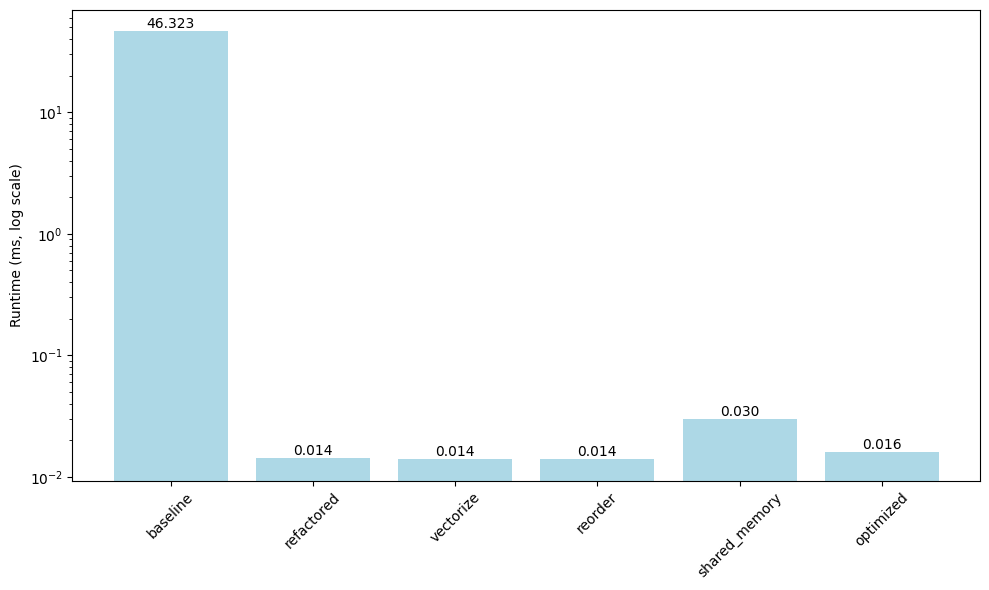

In [16]:
import matplotlib.pyplot as plt
import numpy as np

labels = list(op_runtimes.keys())
runtimes = list(op_runtimes.values())

plt.figure(figsize=(10, 6))

bars = plt.bar(labels, runtimes, color='lightblue')

for bar, rt in zip(bars, runtimes):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{rt:.3f}', ha='center', va='bottom')

plt.ylabel('Runtime (ms, log scale)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


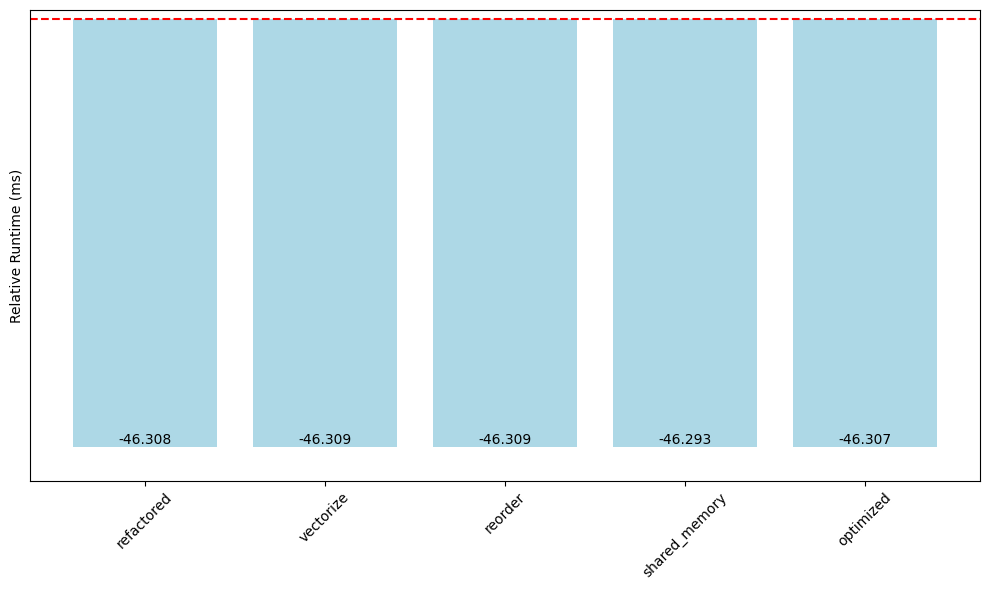

In [17]:
relative_runtimes = [x - op_runtimes['baseline'] for x in runtimes][1:]

plt.figure(figsize=(10, 6))

bars = plt.bar(labels[1:], relative_runtimes, color='lightblue')

for bar, rt in zip(bars, relative_runtimes):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{rt:.3f}', ha='center', va='bottom')

plt.axhline(y=0, color='r', linestyle='--')
plt.ylabel('Relative Runtime (ms)')
plt.ylim(-50, 1)
plt.xticks(rotation=45)
plt.yticks([])
plt.tight_layout()
plt.show()

In [9]:
!git config --global user.email 'wangyixin2002@gmail.com'
!git config --global user.name 'imyixinw'

%cd /content/gdrive/MyDrive/ece5545/a3-{YOUR_HANDLE}

!git pull --rebase origin main

!git add src/ops.py
!git commit -m 'update ops.py for part 2'
!git push origin main

/content/gdrive/MyDrive/ece5545/a3-imyixinw
error: cannot pull with rebase: You have unstaged changes.
error: please commit or stash them.
[main c47f7ea] update ops.py for part 2
 1 file changed, 7 insertions(+), 6 deletions(-)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 465 bytes | 77.00 KiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/ML-HW-SYS/a3-imyixinw.git
   7e25a74..c47f7ea  main -> main


In [67]:
import tvm
import numpy as np
import sys
# Adding assignment 3 to the system path
# Make sure this matches your git directory
sys.path.insert(0, PROJECT_ROOT)
from src.ops import make_conv1d_gpu_baseline

M = 16384
N = 32
dtype = 'float32'
a_np = np.random.rand(M).astype(dtype)
w_np = np.random.rand(N).astype(dtype)
b_np = np.convolve(a_np, w_np)

s, A, W, B = make_conv1d_gpu_baseline(M, N)
func = tvm.build(s, [A, W, B], "cuda")

dev = tvm.cuda(0)
a = tvm.nd.array(a_np, dev)
w = tvm.nd.array(w_np, dev)
b = tvm.nd.array(np.zeros((M+N-1), dtype), dev)
func(a, w, b)
evaluator = func.time_evaluator(func.entry_name, dev, number=1, repeat =1)


print("Answer:", b_np)
print("Output:", b)
print(f"1DConv TVM: %f ms" % (evaluator(a, w, b).mean * 1e3))

Answer: [0.00933708 0.17073123 0.8893703  ... 1.5464524  0.85068005 0.44888914]
Output: [0.00933708 0.17073123 0.8893703  ... 1.5464524  0.85068005 0.44888914]
1DConv TVM: 46.285568 ms
